In [1]:
#!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
print(train_data.shape)
print(test_data.shape)

(70736, 14)
(17685, 14)


# Preprocessing

## Drop delle colonne ritenute superflue, separazione train/test in X, y

In [5]:
X_train = train_data.drop(columns=['No-show', 'AppointmentID', 'PatientId', 'Gender', 'Alcoholism', 'Handcap'])
y_train = train_data['No-show']

X_test = test_data.drop(columns=['No-show', 'AppointmentID', 'PatientId', 'Gender', 'Alcoholism', 'Handcap'])
y_test = test_data['No-show']

## Conversione dei valori Yes/No di No-show in 1/0

In [6]:
y_train = y_train.replace(['Yes', 'No'], [1, 0])
y_test = y_test.replace(['Yes', 'No'], [1, 0])

## Pulizia dati da possibili valori nulli o non conformi

In [7]:
X_train.dtypes

ScheduledDay      object
AppointmentDay    object
Age                int64
Neighbourhood     object
Scholarship        int64
Hipertension       int64
Diabetes           int64
SMS_received       int64
dtype: object

In [8]:
num_columns = ['Scholarship', 'Hipertension', 'Diabetes', 'SMS_received']

In [9]:
X_train = X_train.replace(['', ' ', '?'], np.nan)
X_test = X_test.replace(['', ' ', '?'], np.nan)

X_train = X_train.replace(np.nan, 0)
X_test = X_test.replace(np.nan, 0)

## Conversione delle colonne datetime

In [10]:
X_train_date = X_train.astype({'ScheduledDay': 'datetime64[D]', 'AppointmentDay': 'datetime64[D]'})
X_test_date = X_test.astype({'ScheduledDay': 'datetime64[D]', 'AppointmentDay': 'datetime64[D]'})

In [11]:
X_train_datediff = X_train_date['AppointmentDay'] - X_train_date['ScheduledDay']
X_test_datediff = X_test_date['AppointmentDay'] - X_test_date['ScheduledDay']

In [12]:
X_train_datediff = X_train_datediff.astype('timedelta64[D]')
X_test_datediff = X_test_datediff.astype('timedelta64[D]')
X_train_datediff = X_train_datediff.astype('int64')
X_test_datediff = X_test_datediff.astype('int64')
X_test_datediff

0         2
1        32
2         0
3        14
4        21
         ..
17680     0
17681    22
17682     1
17683    23
17684     0
Length: 17685, dtype: int64

In [13]:
X_train_daydiff = X_train_date
X_train_daydiff['DaysToAppointment'] = X_train_datediff

X_test_daydiff = X_test_date
X_test_daydiff['DaysToAppointment'] = X_test_datediff

In [14]:
X_train_daydiff['AppointmentDay'] = X_train_daydiff['AppointmentDay'].dt.dayofweek
X_train_daydiff['ScheduledDay'] = X_train_daydiff['ScheduledDay'].dt.dayofweek

X_test_daydiff['AppointmentDay'] = X_test_daydiff['AppointmentDay'].dt.dayofweek
X_test_daydiff['ScheduledDay'] = X_test_daydiff['ScheduledDay'].dt.dayofweek

In [15]:
X_train_daydiff.dtypes

ScheduledDay          int64
AppointmentDay        int64
Age                   int64
Neighbourhood        object
Scholarship           int64
Hipertension          int64
Diabetes              int64
SMS_received          int64
DaysToAppointment     int64
dtype: object

In [16]:
X_train_daydiff.head()

,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,SMS_received,DaysToAppointment
0,4,4,21,SÃO CRISTÓVÃO,0,0,0,0,0
1,3,4,95,CENTRO,0,1,0,0,1
2,2,3,71,CRUZAMENTO,0,0,0,0,1
3,2,4,18,CARATOÍRA,0,0,0,0,2
4,2,2,45,PRAIA DO SUÁ,1,0,0,0,0


## Codifica delle classi di Neighbourhood (LabelEncoding)

In caso di classe poco frequente (<1250 pazienti in un neighbourhood) essa viene codificata con "Other", questo anche per i dati di test, così da evitare possibili errori nel LabelEncoding per nuove classi non viste in precedenza (nel fit). I valori di neighbour iniettati sono ordinati per la probabilità di No-show del train set di ogni neighbourhood (vedere notebook di preparazione).

In [17]:
neighbour_count = X_train_daydiff['Neighbourhood'].value_counts()

def neighbour_bin(name):
    if (not name in neighbour_count.index):
        return 'Other'
    elif (neighbour_count[name]) < 1250:
        return 'Other'
    else:
        return name

In [18]:
X_train_daydiff['Neighbourhood'] = X_train_daydiff['Neighbourhood'].apply(lambda n: neighbour_bin(n))
X_test_daydiff['Neighbourhood'] = X_test_daydiff['Neighbourhood'].apply(lambda n: neighbour_bin(n))

In [19]:
X_train_daydiff.head()

,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,SMS_received,DaysToAppointment
0,4,4,21,Other,0,0,0,0,0
1,3,4,95,CENTRO,0,1,0,0,1
2,2,3,71,Other,0,0,0,0,1
3,2,4,18,CARATOÍRA,0,0,0,0,2
4,2,2,45,Other,1,0,0,0,0


In [20]:
train_full = pd.concat([y_train, X_train_daydiff], axis=1)
ordered = train_full[['Neighbourhood', 'No-show']].groupby(['Neighbourhood']).mean().sort_values(by='No-show', ascending=False)
ordered.head()

,No-show
Neighbourhood,
ITARARÉ,0.249779
JESUS DE NAZARETH,0.242088
ILHA DO PRÍNCIPE,0.235940
ANDORINHAS,0.228975
CARATOÍRA,0.225826


In [21]:
df_ordered = pd.DataFrame(data=ordered)
df_ordered = df_ordered.reset_index()
print(df_ordered[df_ordered['Neighbourhood']=='Other'])
df_ordered.head()

   Neighbourhood   No-show
15         Other  0.197107


,Neighbourhood,No-show
0,ITARARÉ,0.249779
1,JESUS DE NAZARETH,0.242088
2,ILHA DO PRÍNCIPE,0.235940
3,ANDORINHAS,0.228975
4,CARATOÍRA,0.225826


In [22]:
df_ordered[df_ordered['Neighbourhood'] == 'JABOUR'].index[0]

19

In [23]:
def lookup_neighbour_order(name):
    return df_ordered[df_ordered['Neighbourhood'] == name].index[0]

In [24]:
series_labeled = X_train_daydiff['Neighbourhood'].apply(lambda n: lookup_neighbour_order(n))
series_labeled

0        15
1         8
2        15
3         4
4        15
         ..
70731     0
70732    22
70733    16
70734    15
70735    20
Name: Neighbourhood, Length: 70736, dtype: int64

In [25]:
series_labeled.unique()

array([15,  8,  4, 14,  5, 10,  6, 18, 19, 16, 12, 22, 13, 17,  0,  1, 20,
       11, 21,  3,  9,  2,  7], dtype=int64)

In [26]:
X_train_daydiff.head()

,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,SMS_received,DaysToAppointment
0,4,4,21,Other,0,0,0,0,0
1,3,4,95,CENTRO,0,1,0,0,1
2,2,3,71,Other,0,0,0,0,1
3,2,4,18,CARATOÍRA,0,0,0,0,2
4,2,2,45,Other,1,0,0,0,0


In [27]:
test_series_labeled = X_test_daydiff['Neighbourhood'].apply(lambda n: lookup_neighbour_order(n))

In [30]:
X_train_daydiff['Neighbourhood'] = series_labeled
X_test_daydiff['Neighbourhood'] = test_series_labeled
X_train_daydiff

,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,SMS_received,DaysToAppointment
0,4,4,21,15,0,0,0,0,0
1,3,4,95,8,0,1,0,0,1
2,2,3,71,15,0,0,0,0,1
3,2,4,18,4,0,0,0,0,2
4,2,2,45,15,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
70731,2,3,30,0,0,1,0,1,8
70732,1,1,1,22,0,0,0,0,0
70733,4,2,43,16,0,0,0,1,61
70734,0,2,17,15,0,0,0,0,2


In [31]:
X_train_daydiff.Neighbourhood.value_counts()

15    26823
16     4991
9      3639
10     2870
21     2497
0      2258
8      2116
22     2020
18     1989
1      1801
20     1777
14     1773
12     1658
4      1634
19     1608
11     1599
2      1458
7      1439
13     1427
3      1415
17     1403
5      1289
6      1252
Name: Neighbourhood, dtype: int64

In [32]:
X_train_temp = X_train_daydiff
X_test_temp = X_test_daydiff

In [33]:
X_train_temp = X_train_temp.drop(columns=['ScheduledDay'])
X_test_temp = X_test_temp.drop(columns=['ScheduledDay'])

# LabelEncoding

In [34]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()

In [35]:
#X_train_date['Neighbourhood'] = le.fit_transform(X_train_daydiff['Neighbourhood'])
#X_train_date['Neighbourhood'].head(10)

In [36]:
#le.classes_

In [37]:
#X_test_label = le.transform(X_test_date['Neighbourhood'])

### Matrice di correlazione delle feature

In [38]:
X_train_full = pd.concat([y_train, X_train_temp], axis=1)

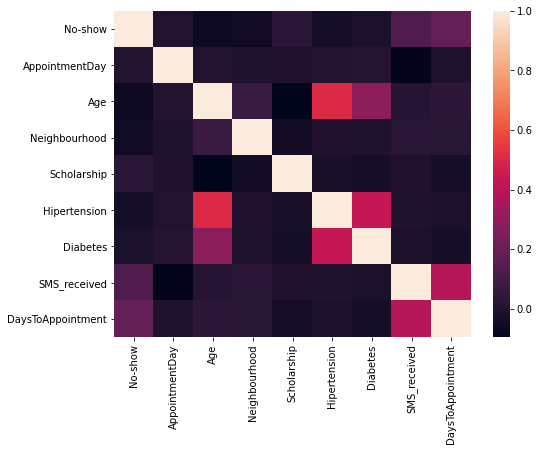

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(X_train_full.corr(), annot=False)
plt.show()

# Scelta dei modelli, training e fit

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [43]:
X_train = X_train_temp
X_test = X_test_temp

In [44]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
        ('inputer', SimpleImputer(strategy='median')),
        ('ohe', OneHotEncoder(handle_unknown='ignore')),
        ('model', DecisionTreeClassifier())
        ])

In [45]:
params = [
            {'model': [DecisionTreeClassifier()],
            'model__max_depth': np.arange(1,26)},
            {'model': [LogisticRegression()],
            'model__max_iter': [2000],
            'model__penalty': ['l2'], #[['l1', 'l2']]
            'model__C': np.logspace(0, 4, 15)},
            {'model': [RandomForestClassifier()],
            'model__n_estimators': [10, 100, 1000],
            'model__max_features': [1, 2, 3]},
            {'model': [KNeighborsClassifier()],
             'model__n_neighbors': np.arange(2,6),
             'model__leaf_size': list(range(15,35)),
             'model__p': [1, 2]}
            ]

In [ ]:
from sklearn.model_selection import GridSearchCV
gridsearch = GridSearchCV(pipe, params, cv=2, verbose=1).fit(X_train, y_train) #specificare cv=5
print('Score finale di test: ', gridsearch.score(X_test, y_test))

Fitting 2 folds for each of 209 candidates, totalling 418 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
gs = pd.DataFrame(gridsearch.cv_results_)
gs[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score', ascending=True).head(10)

In [ ]:
gridsearch.best_estimator_.get_params()

In [ ]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows = 1, ncols = 1, sharex="all", figsize=(6,4))

indices = np.argsort( gridsearch.best_estimator_[0].feature_importances_)[::-1][:40]
g = sns.barplot(y=X_train.columns[indices][:40],x = gridsearch.best_estimator_[0].feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title('DecisionTreeClassifier' + " feature importance")

## DecisionTree

In [ ]:
max_loop_depth = 40
max_score = 0
best_depth = 0

for depth in range(1, max_loop_depth):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    if(score > max_score):
        max_score = score
        best_depth = depth
    
best_model = DecisionTreeClassifier(max_depth=best_depth, random_state=1)
best_model.fit(X_train, y_train)

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharex="all", figsize=(6, 4))

indices = np.argsort(best_model.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_train.columns[indices][:40],x = best_model.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title('DecisionTreeClassifier' + " feature importance")

In [ ]:
print('Training Accuracy: ', best_model.score(X_train, y_train) * 100, '%')
print('Testing Accuracy: ', best_model.score(X_test, y_test) * 100, '%')

## LogisticRegression

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=1)
model.fit(X_train, y_train)

In [ ]:
print('Training Accuracy: ', model.score(X_train, y_train) * 100, '%')
print('Testing Accuracy: ', model.score(X_test, y_test) * 100, '%')

## RandomForest

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(X_train, y_train)

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharex="all", figsize=(6, 4))

indices = np.argsort(model.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_train.columns[indices][:40],x = model.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title('RandomForestClassifier' + " feature importance")

In [ ]:
print('Training Accuracy: ', model.score(X_train, y_train) * 100, '%')
print('Testing Accuracy: ', model.score(X_test, y_test) * 100, '%')